In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv(
  "london_bike_sharing.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [3]:
df.shape

(17414, 9)

In [4]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

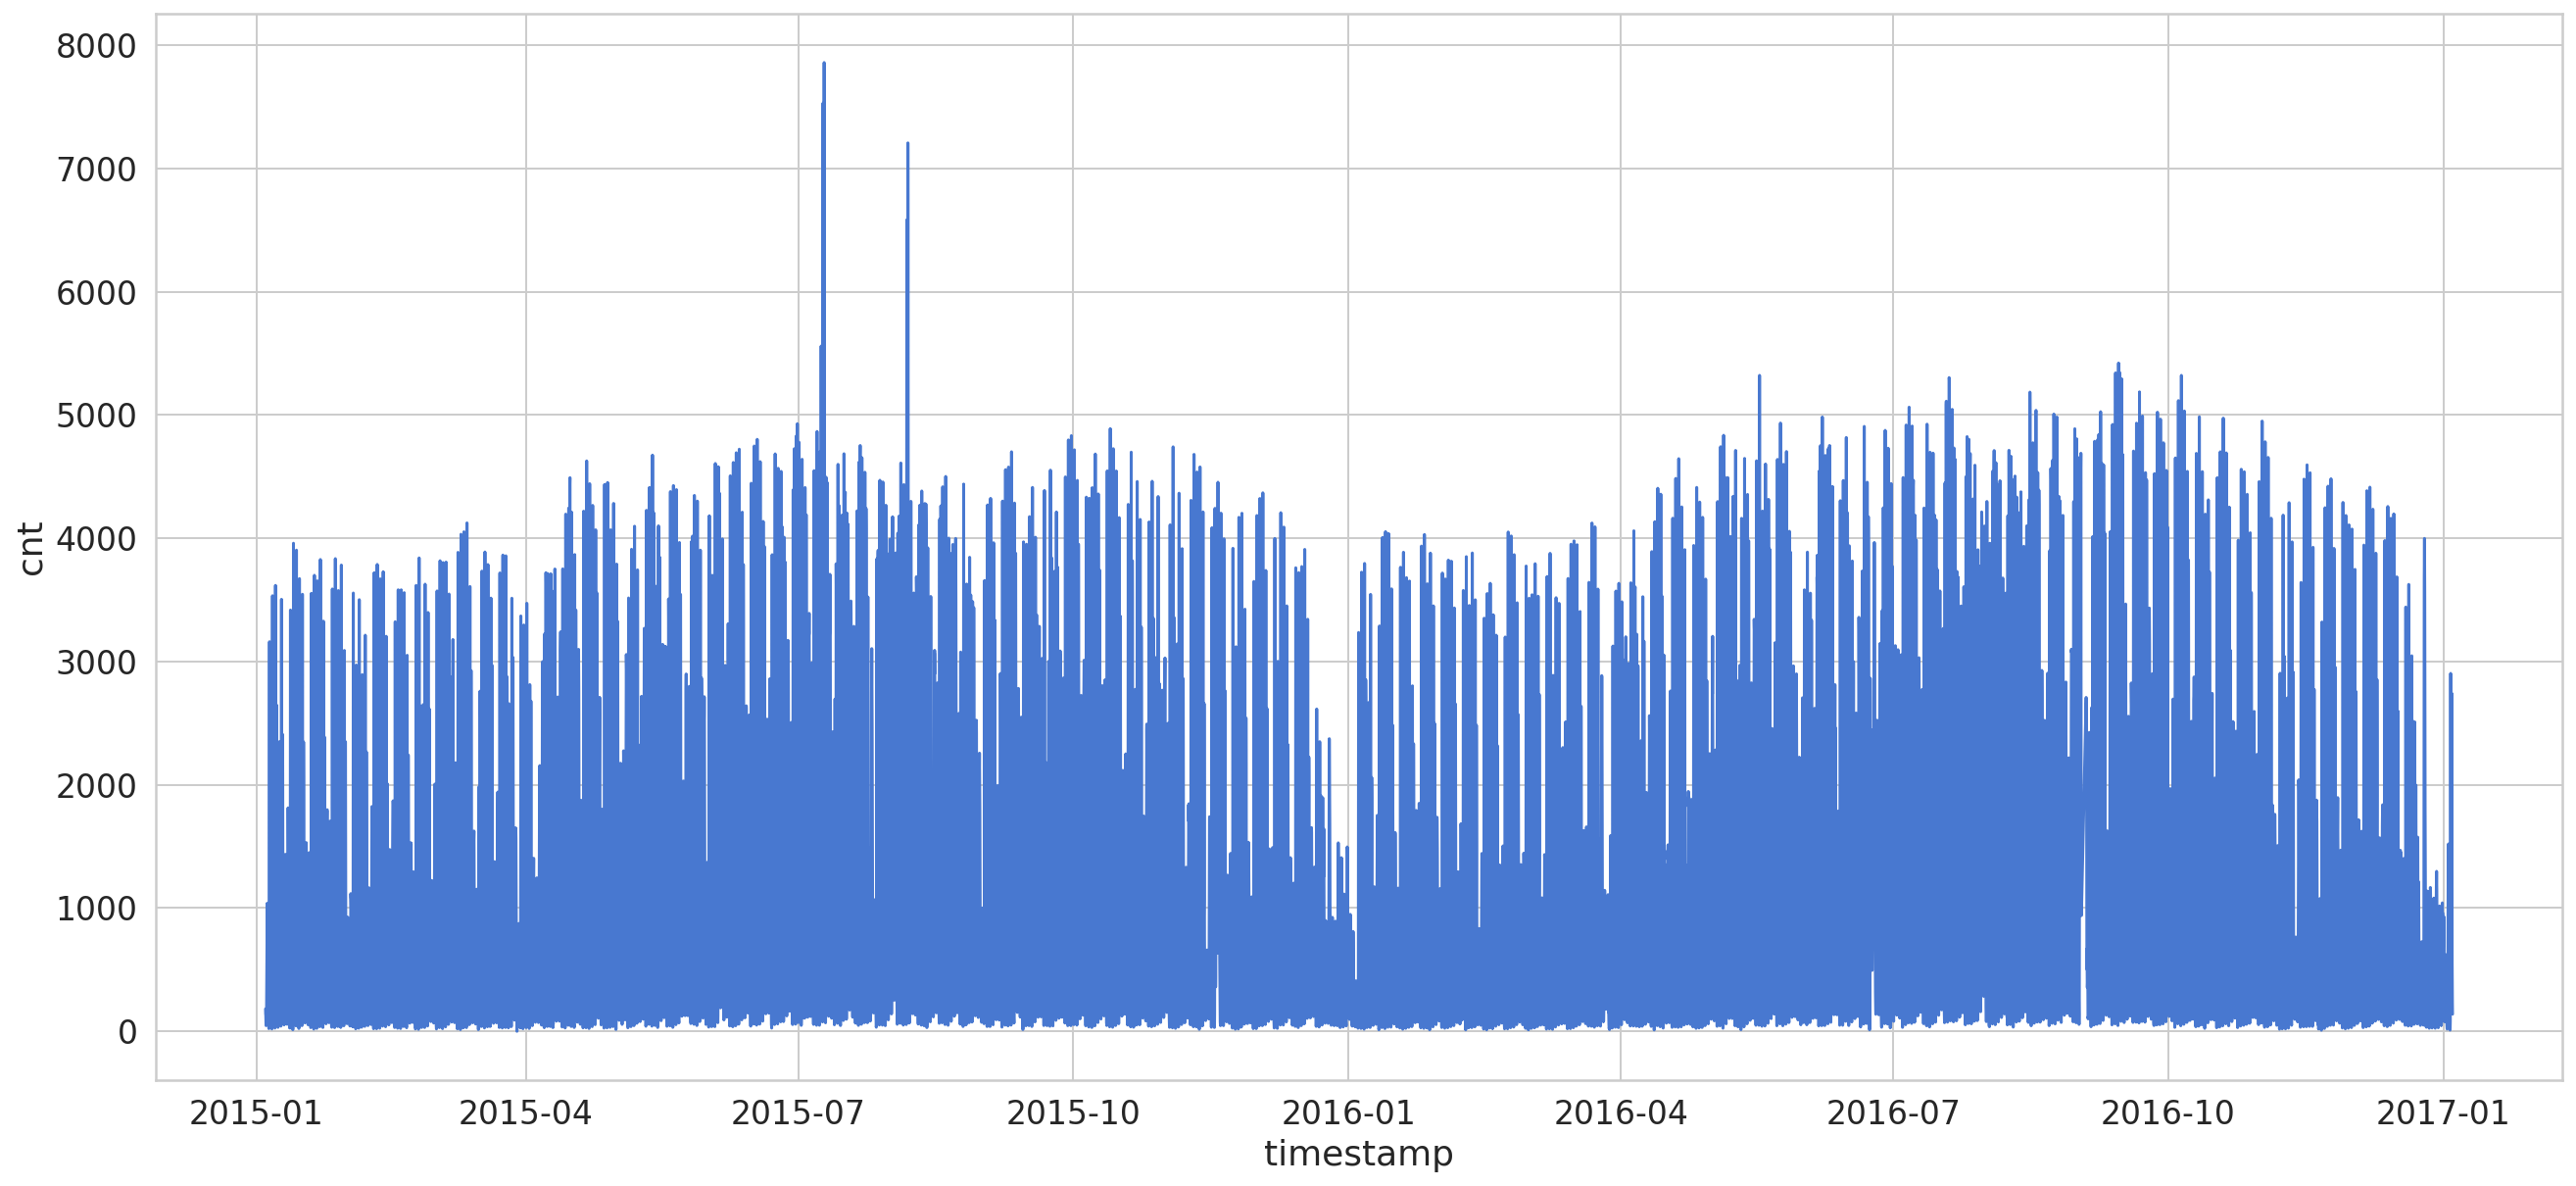

In [6]:
sns.lineplot(x=df.index, y="cnt", data=df);

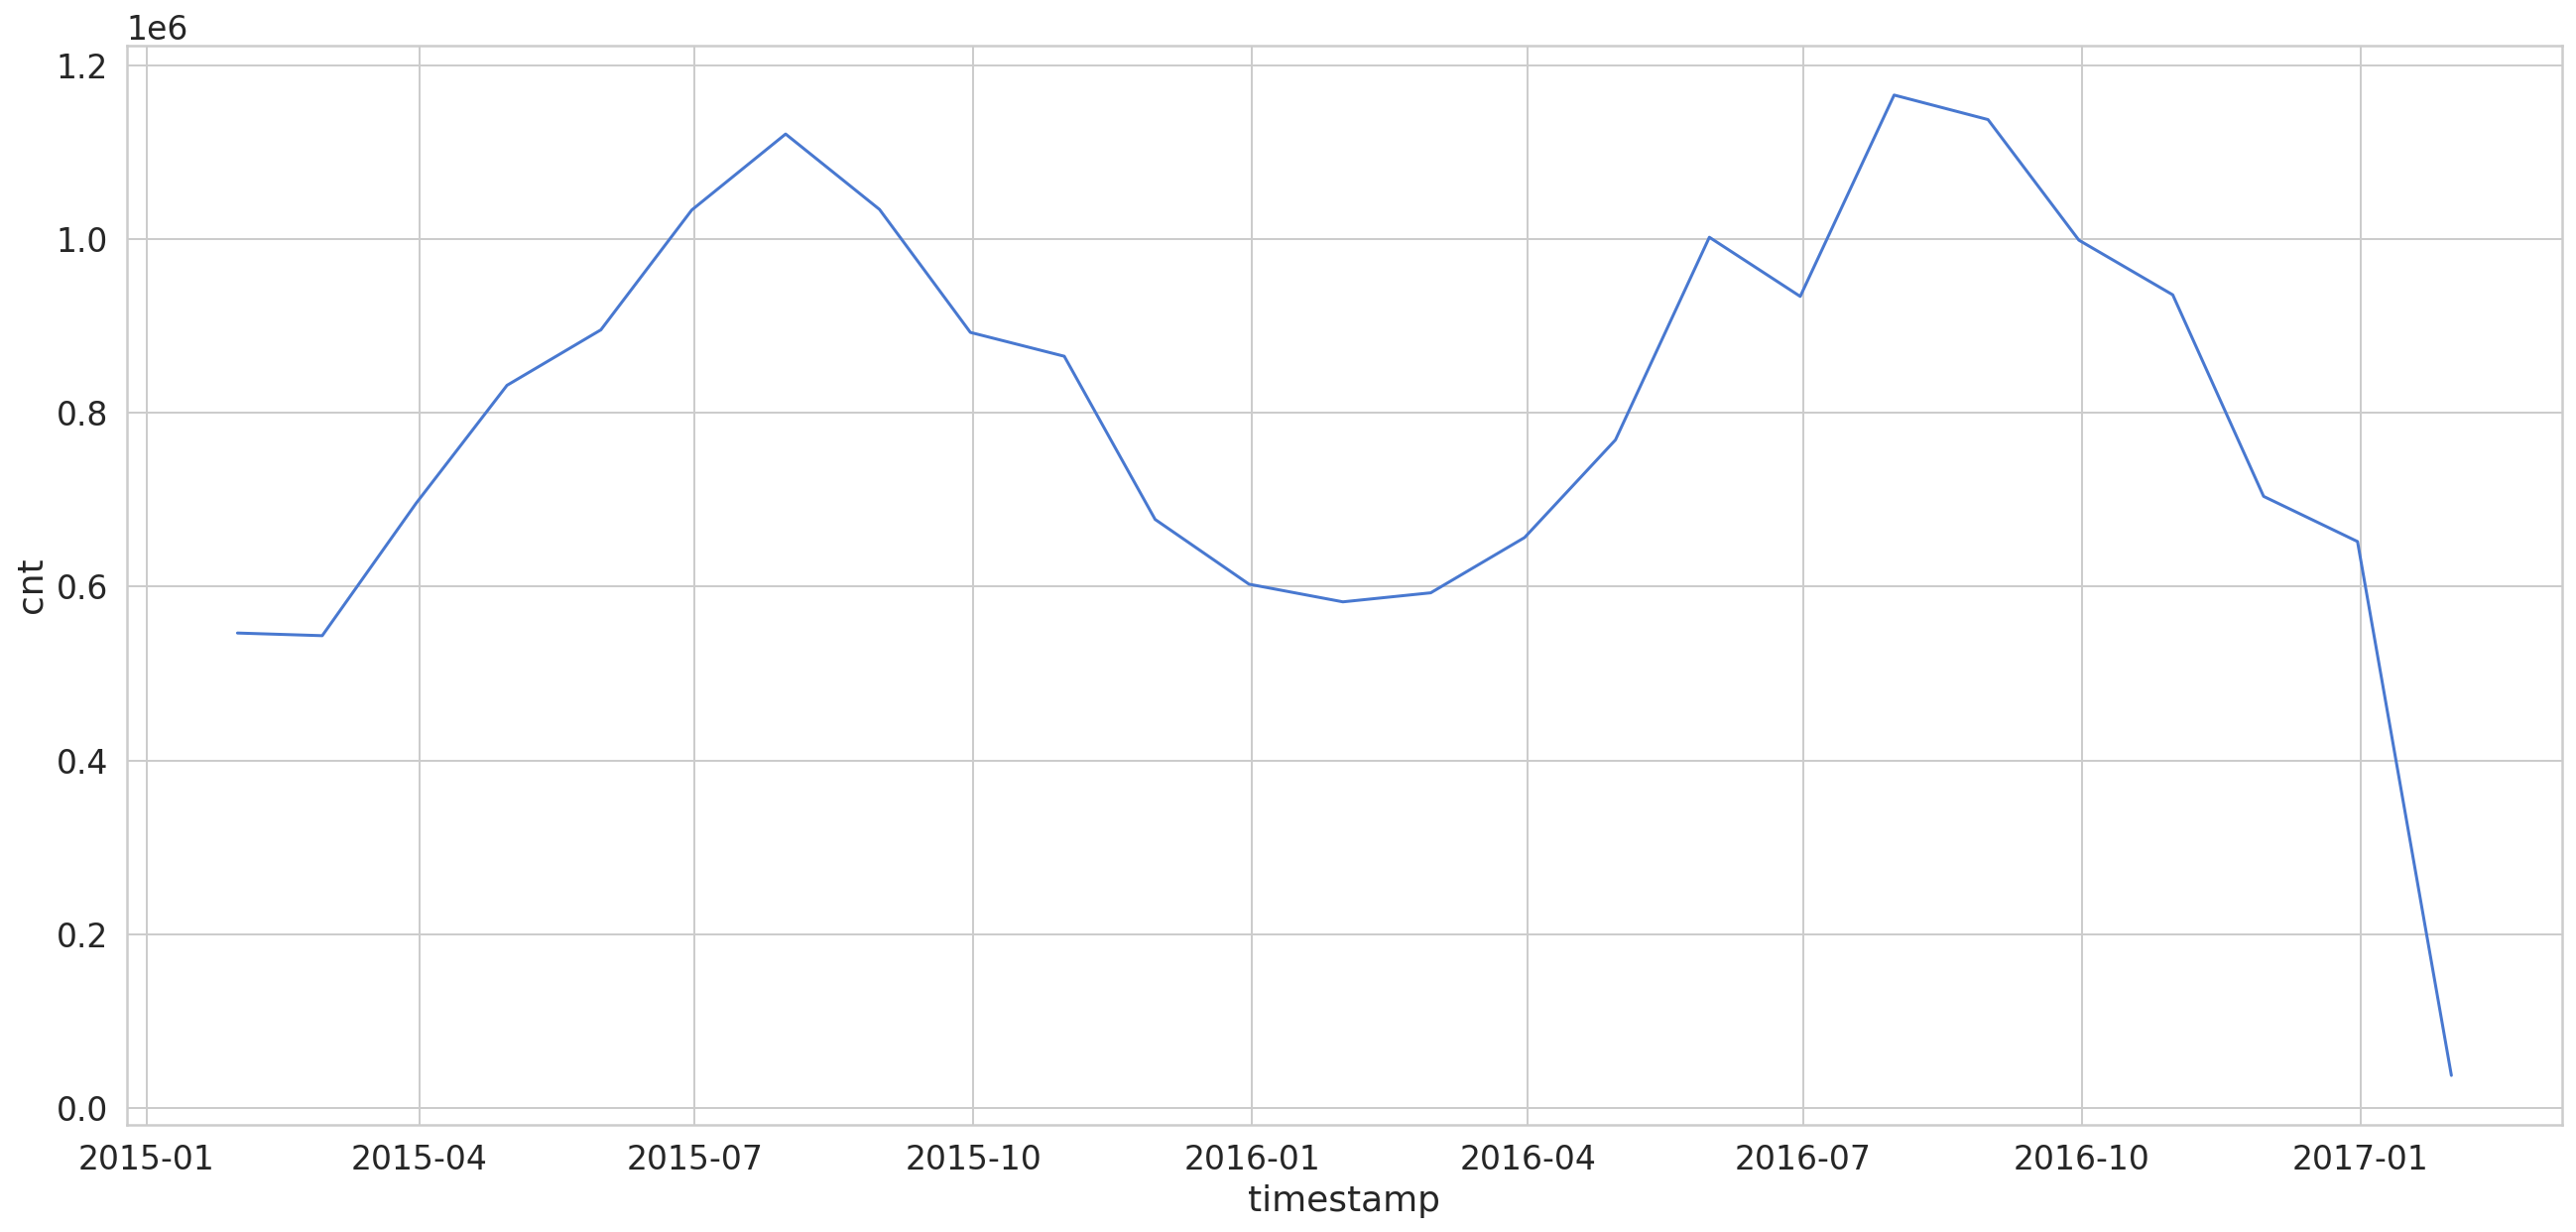

In [7]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

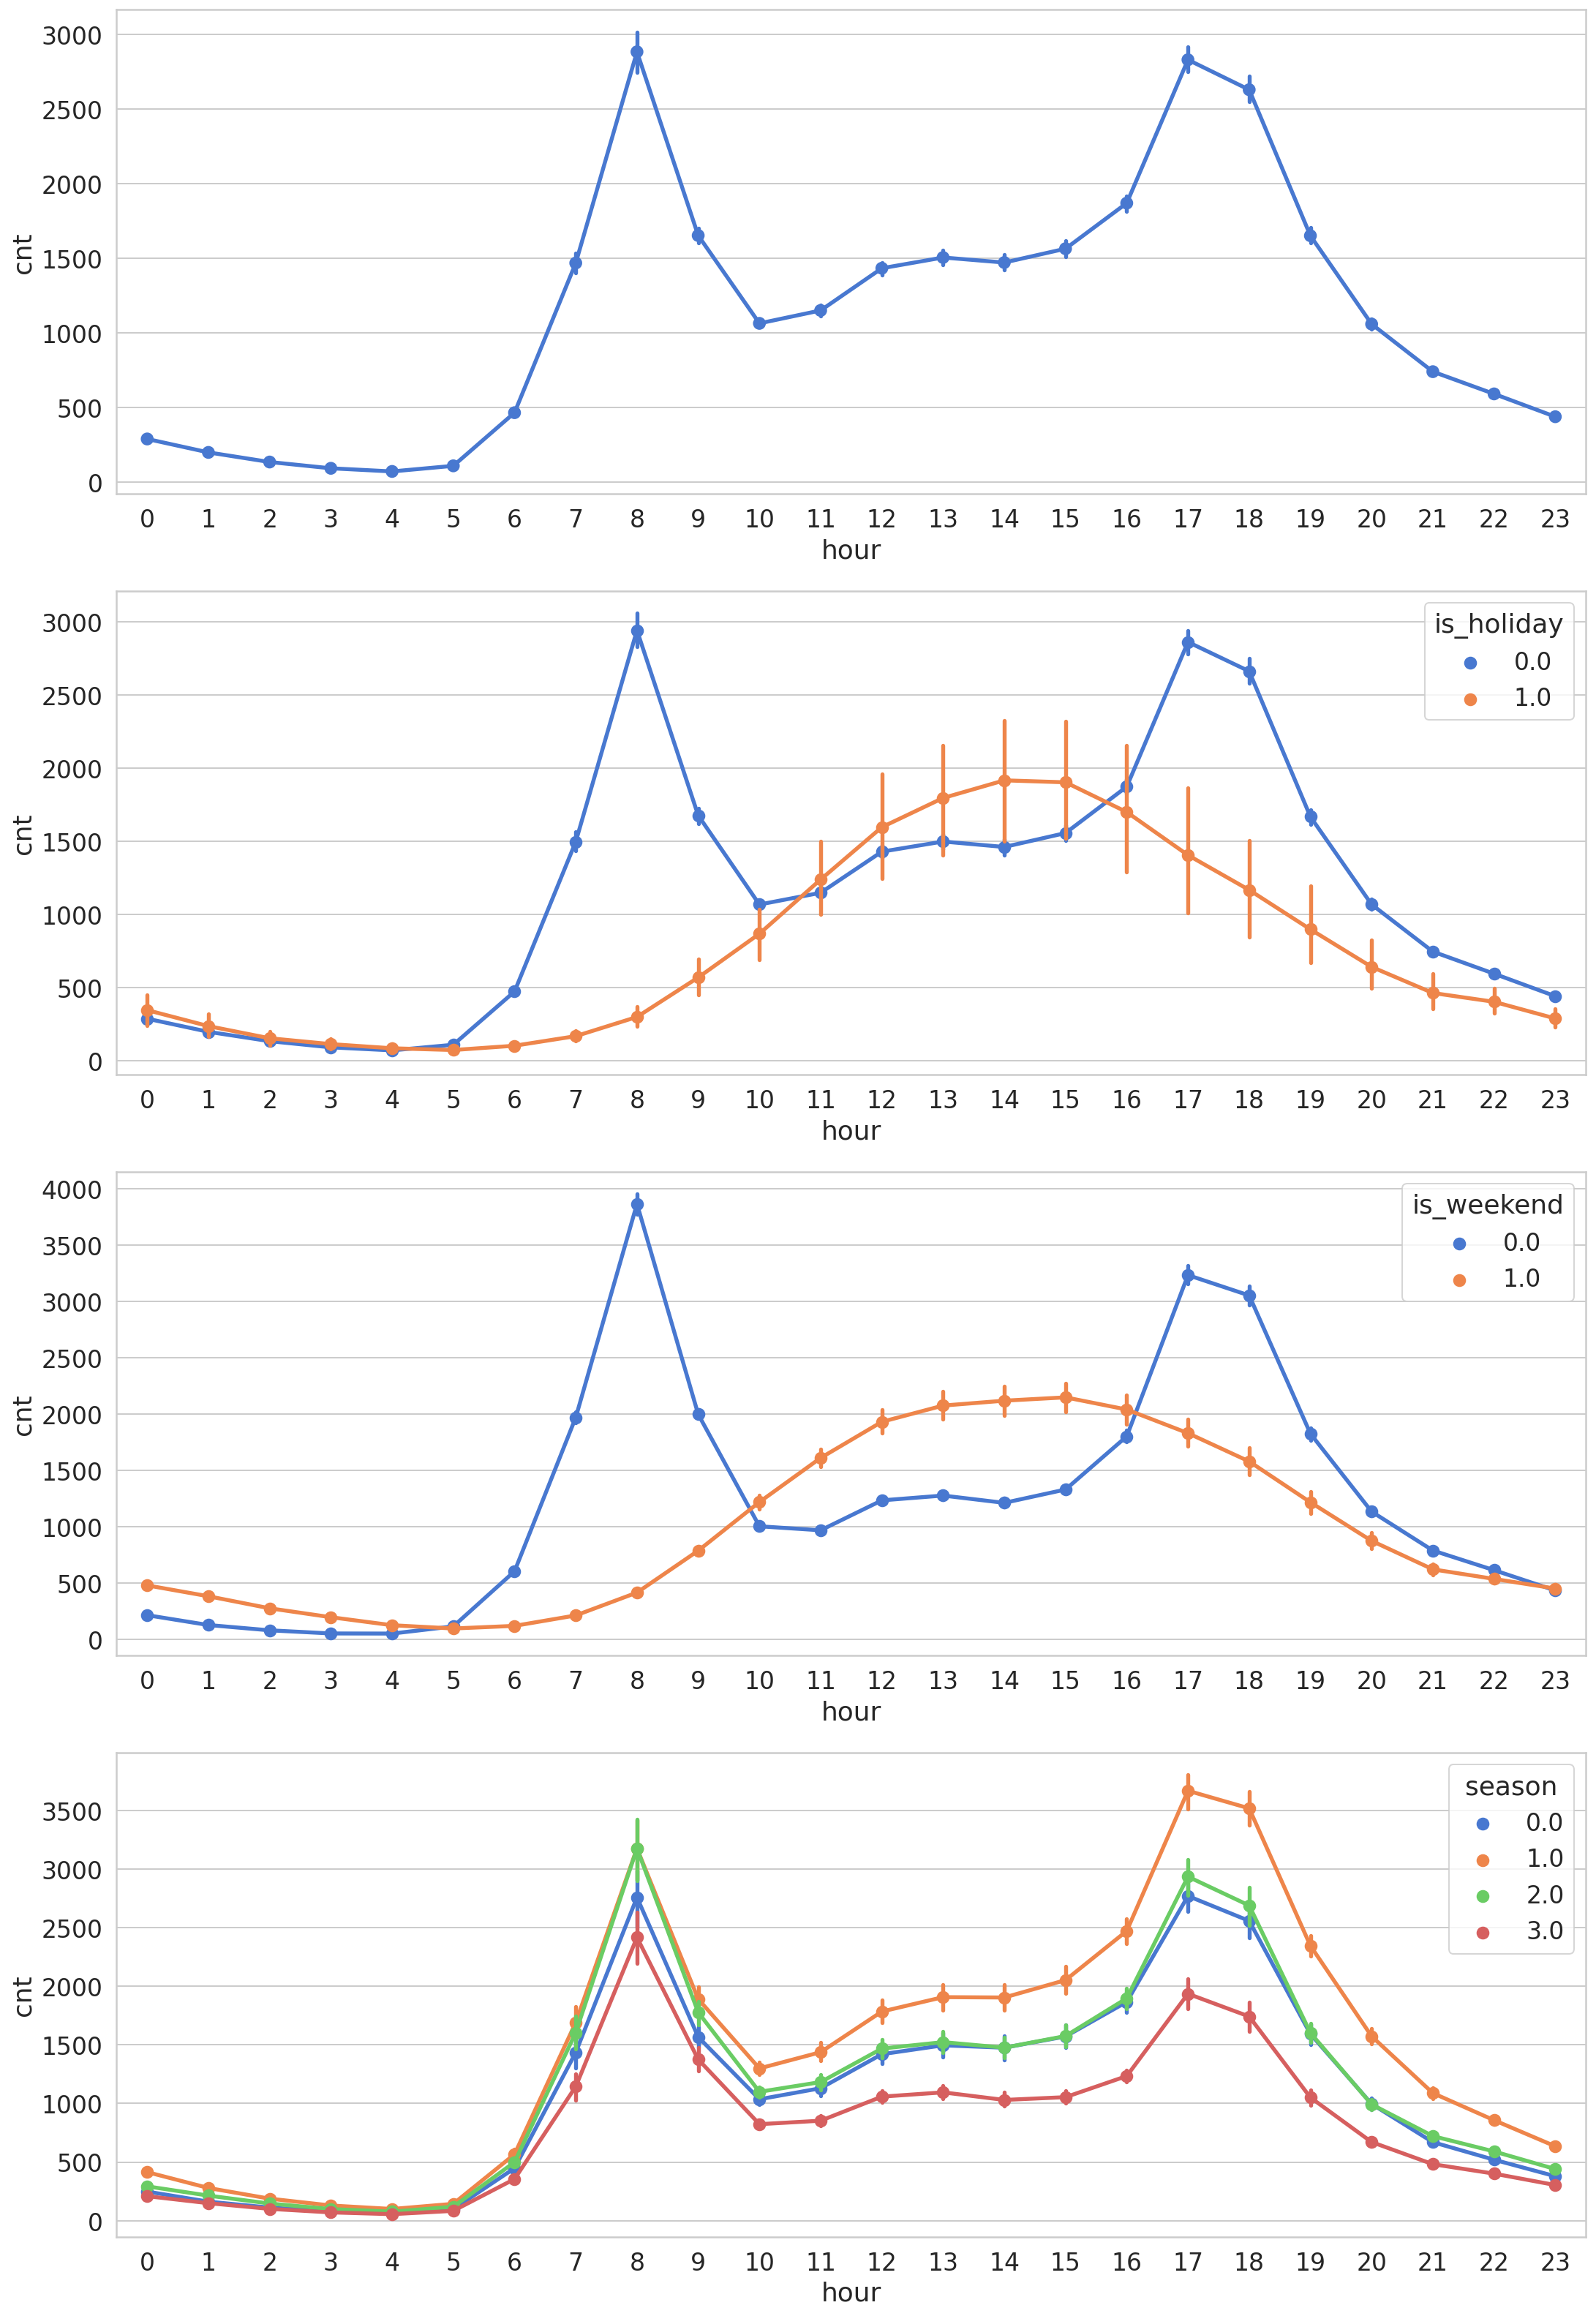

In [8]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

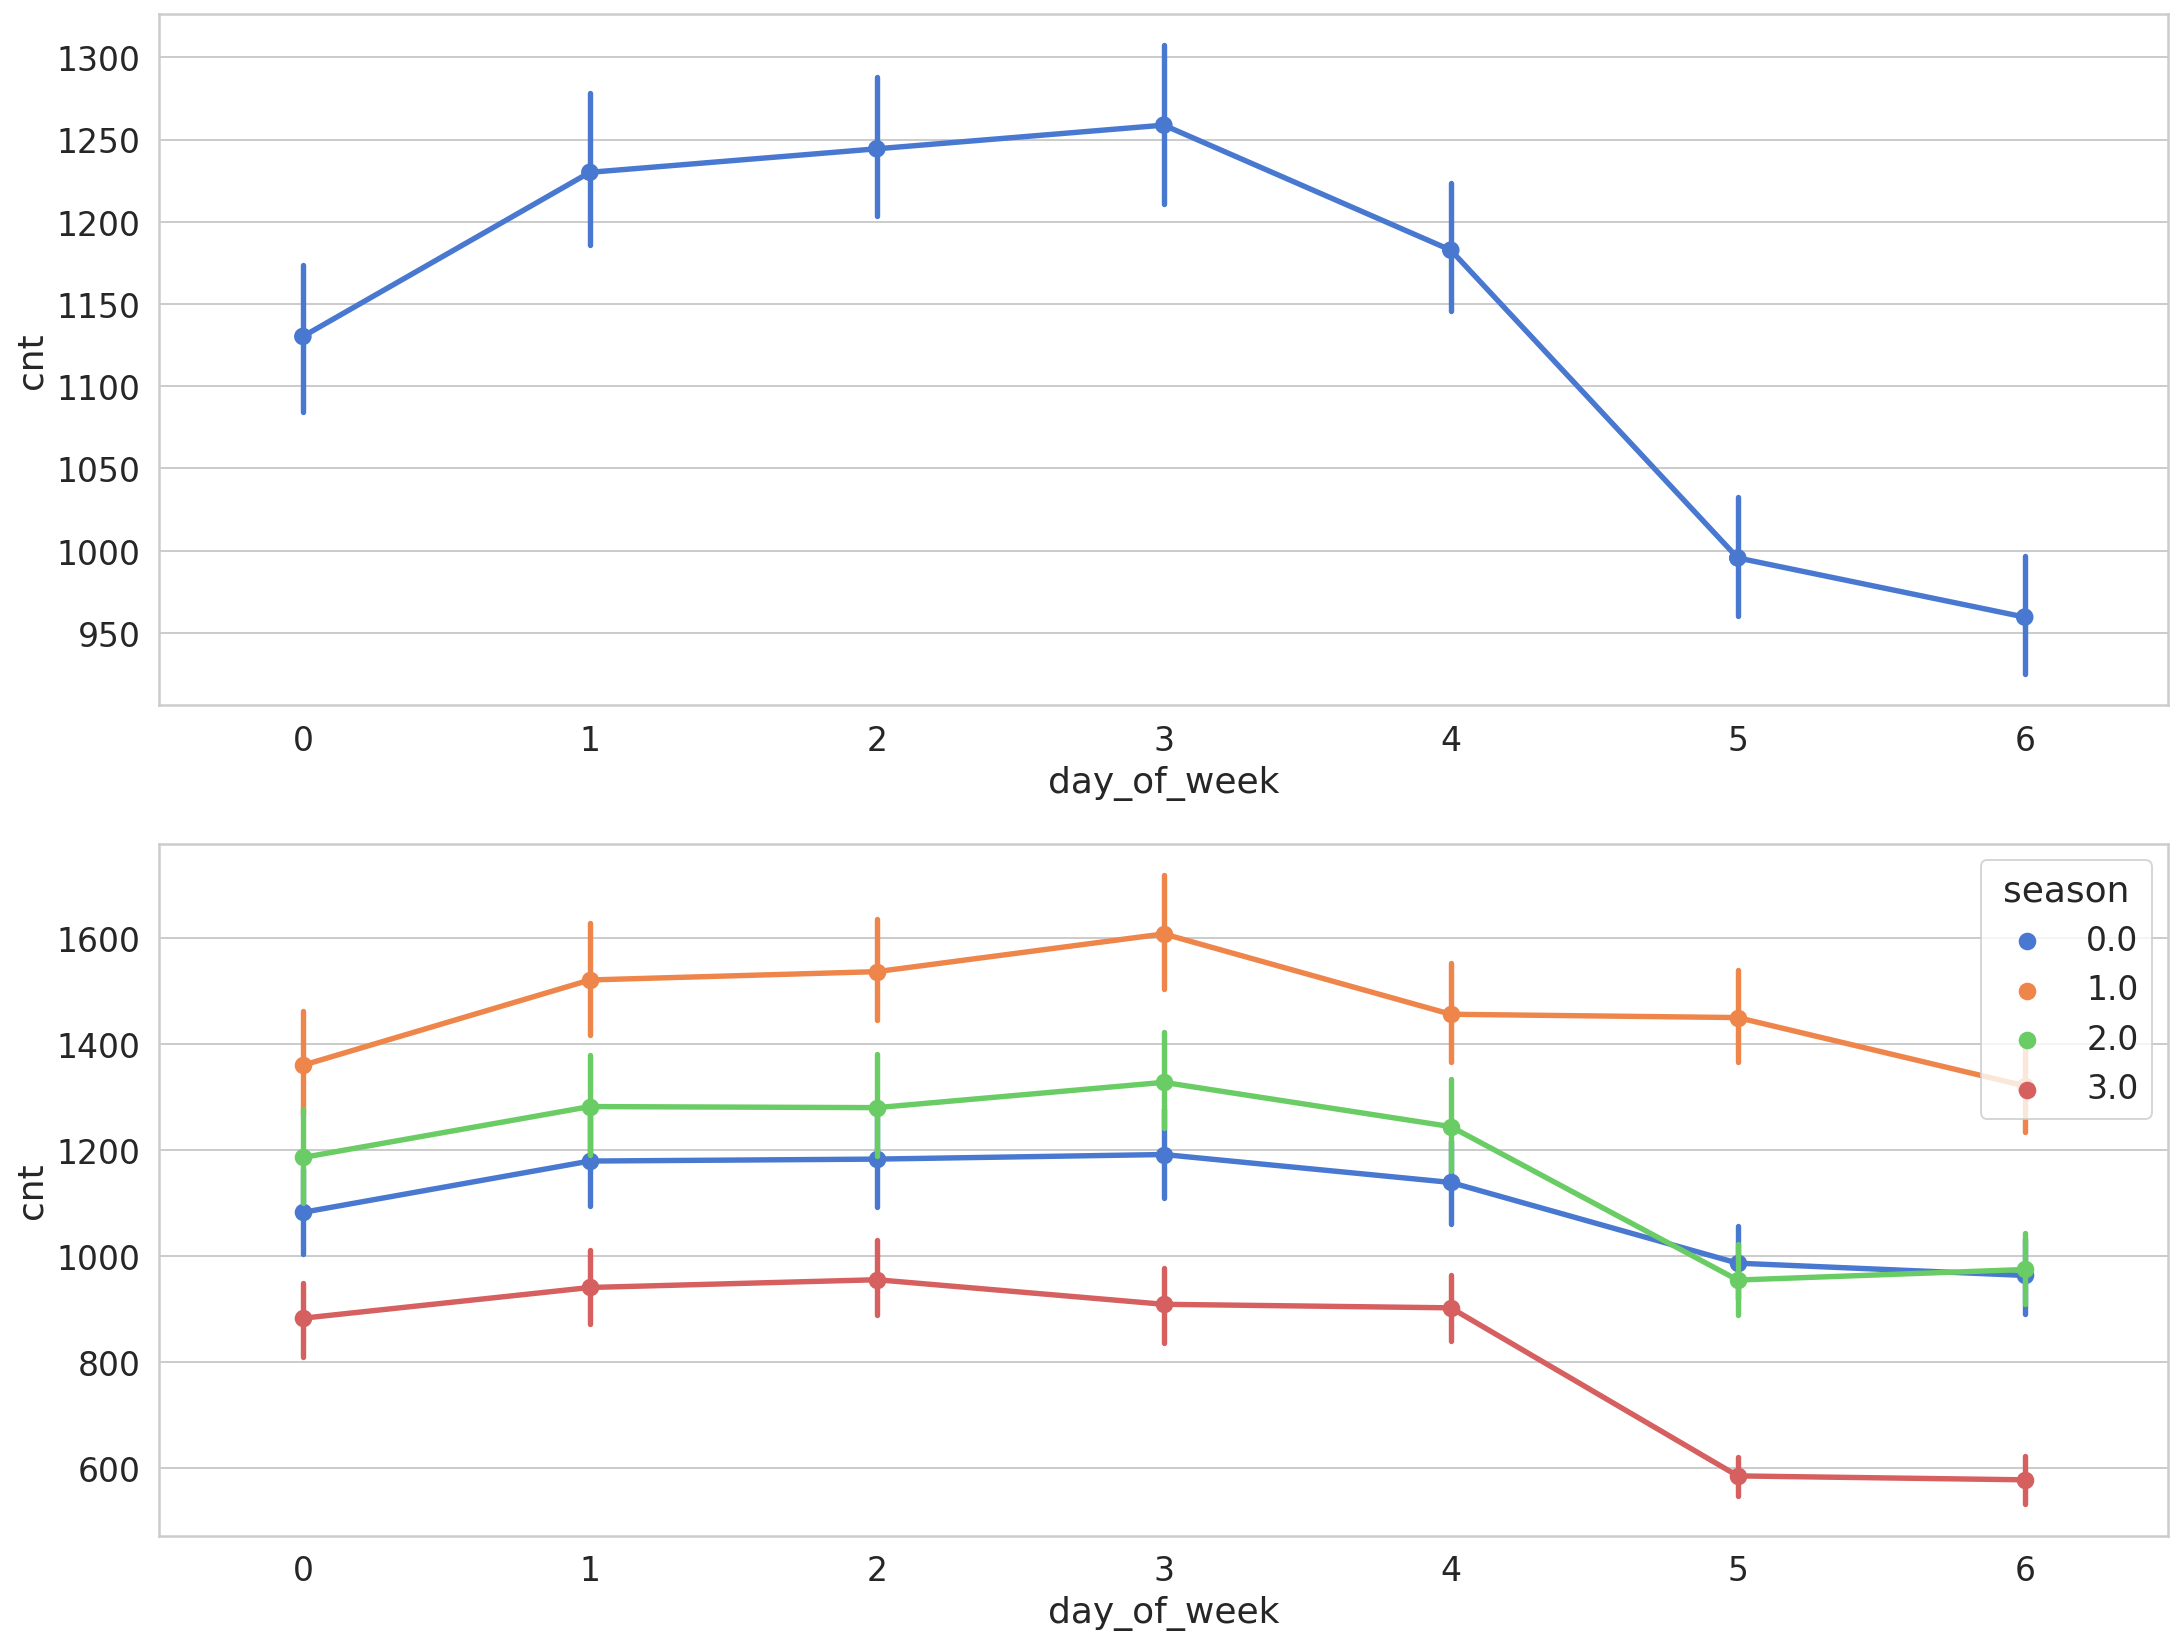

In [9]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

In [10]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


# Preprocessing

In [11]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/home/venom/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-11-92b06493bae2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = cnt_transformer.transform(train[['cnt']])
/home/venom/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [12]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [13]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


In [14]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

441/441 [==============================] - 6s 13ms/step - loss: 0.3270 - val_loss: 0.1255
Epoch 2/30
441/441 [==============================] - 5s 12ms/step - loss: 0.0818 - val_loss: 0.0661
Epoch 3/30
441/441 [==============================] - 6s 13ms/step - loss: 0.0512 - val_loss: 0.0552
Epoch 4/30
441/441 [==============================] - 7s 15ms/step - loss: 0.0389 - val_loss: 0.0356
Epoch 5/30
441/441 [==============================] - 9s 20ms/step - loss: 0.0306 - val_loss: 0.0310
Epo

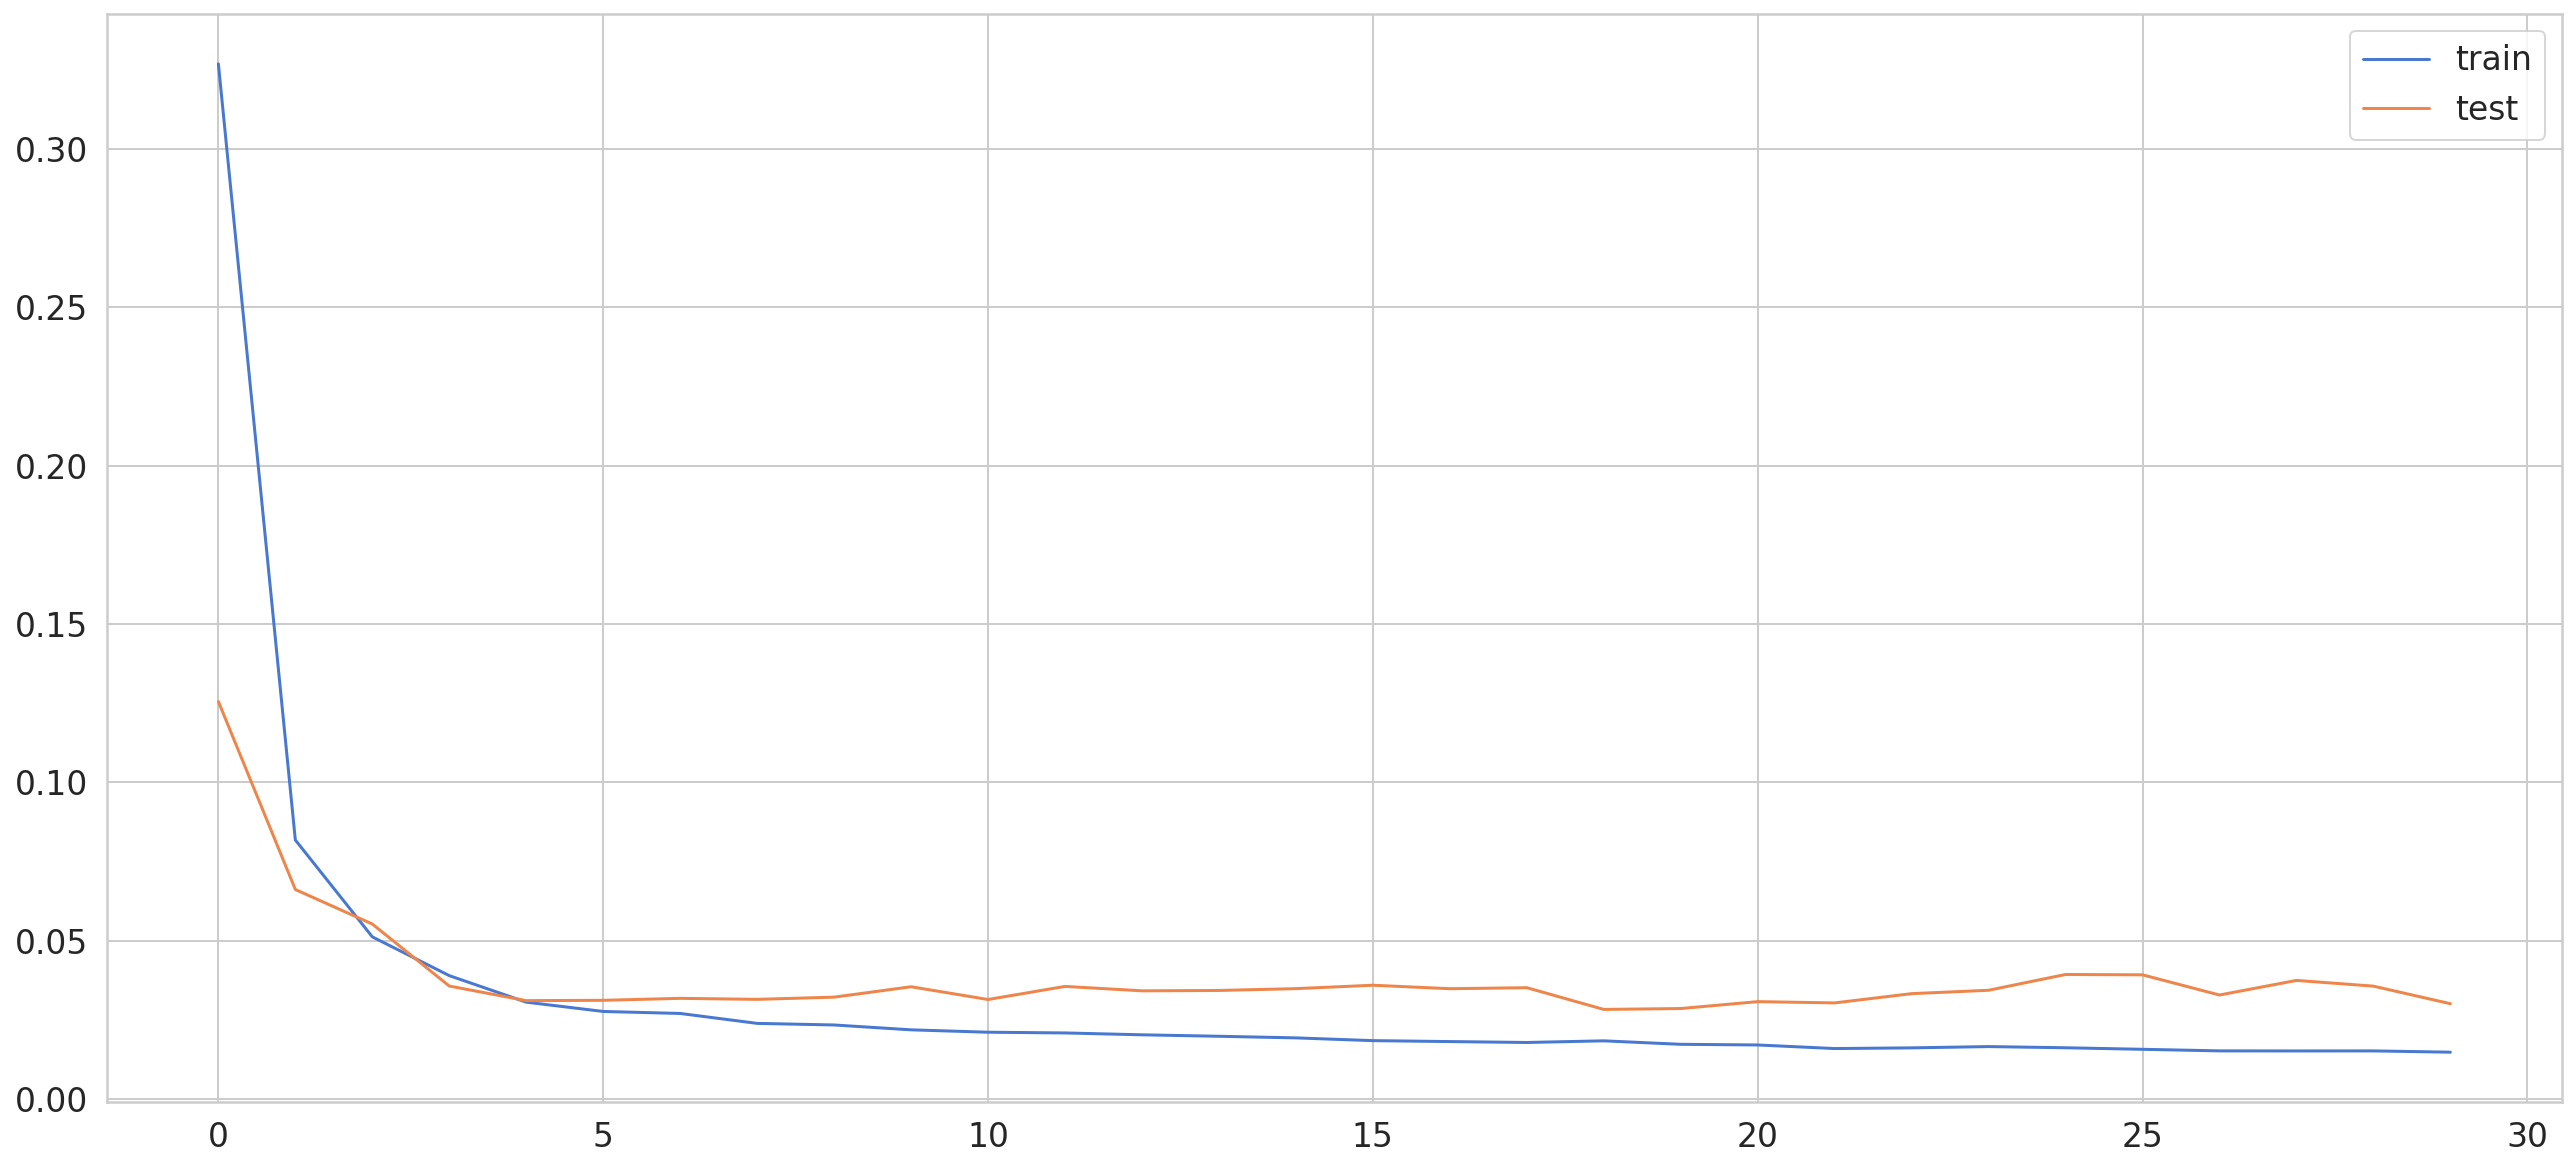

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [17]:
y_pred = model.predict(X_test)

In [18]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

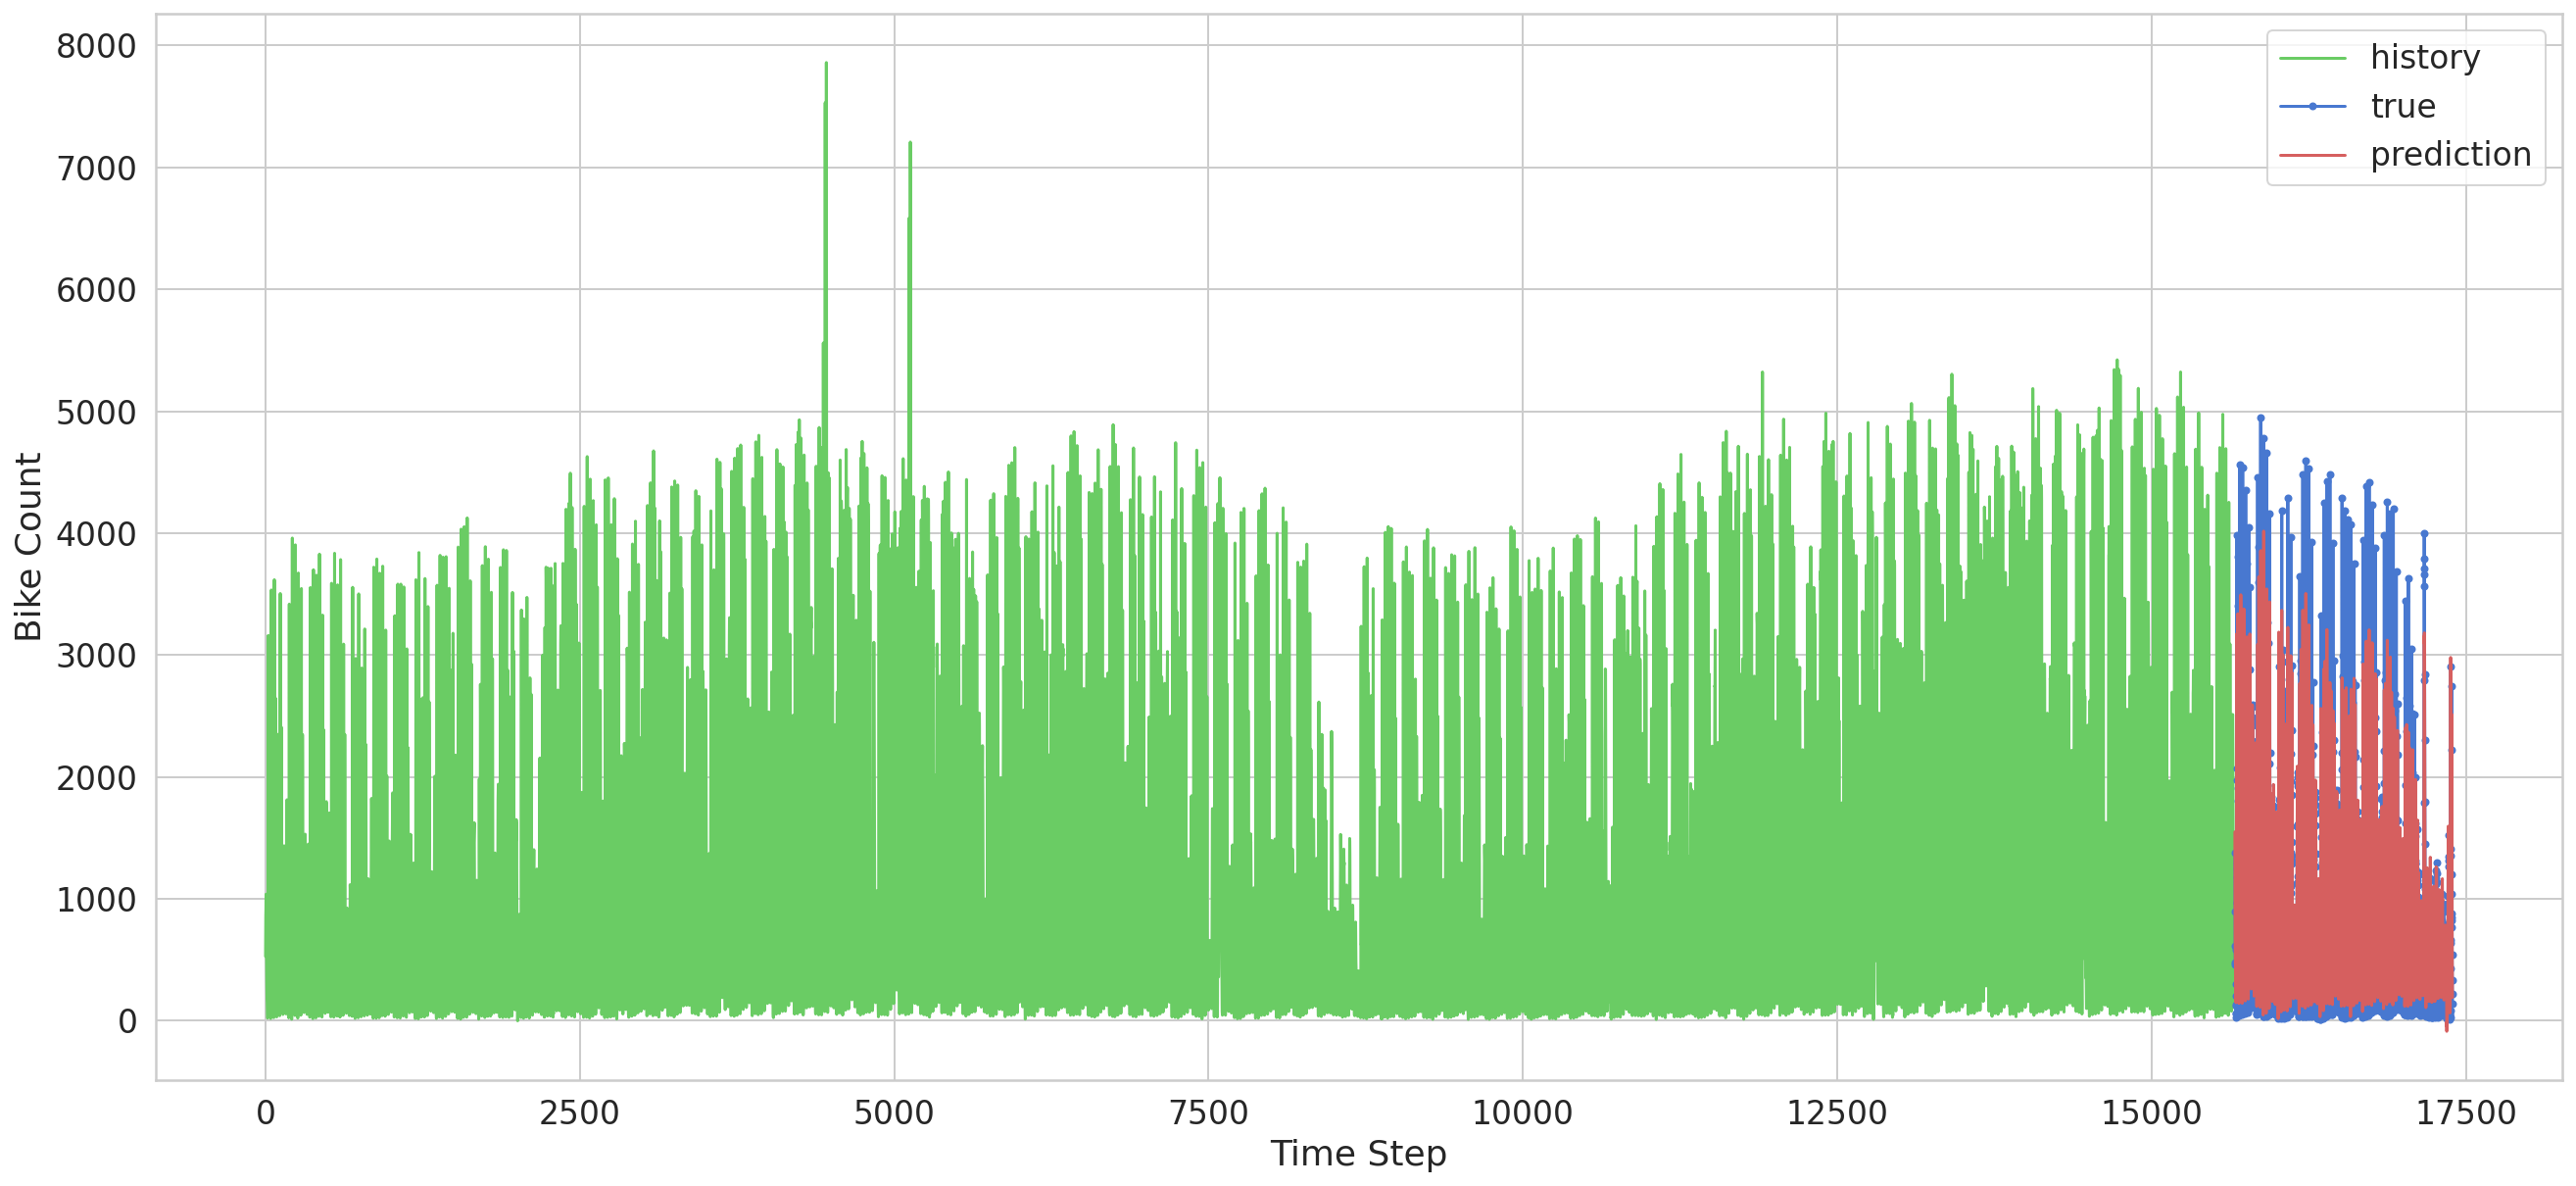

In [19]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

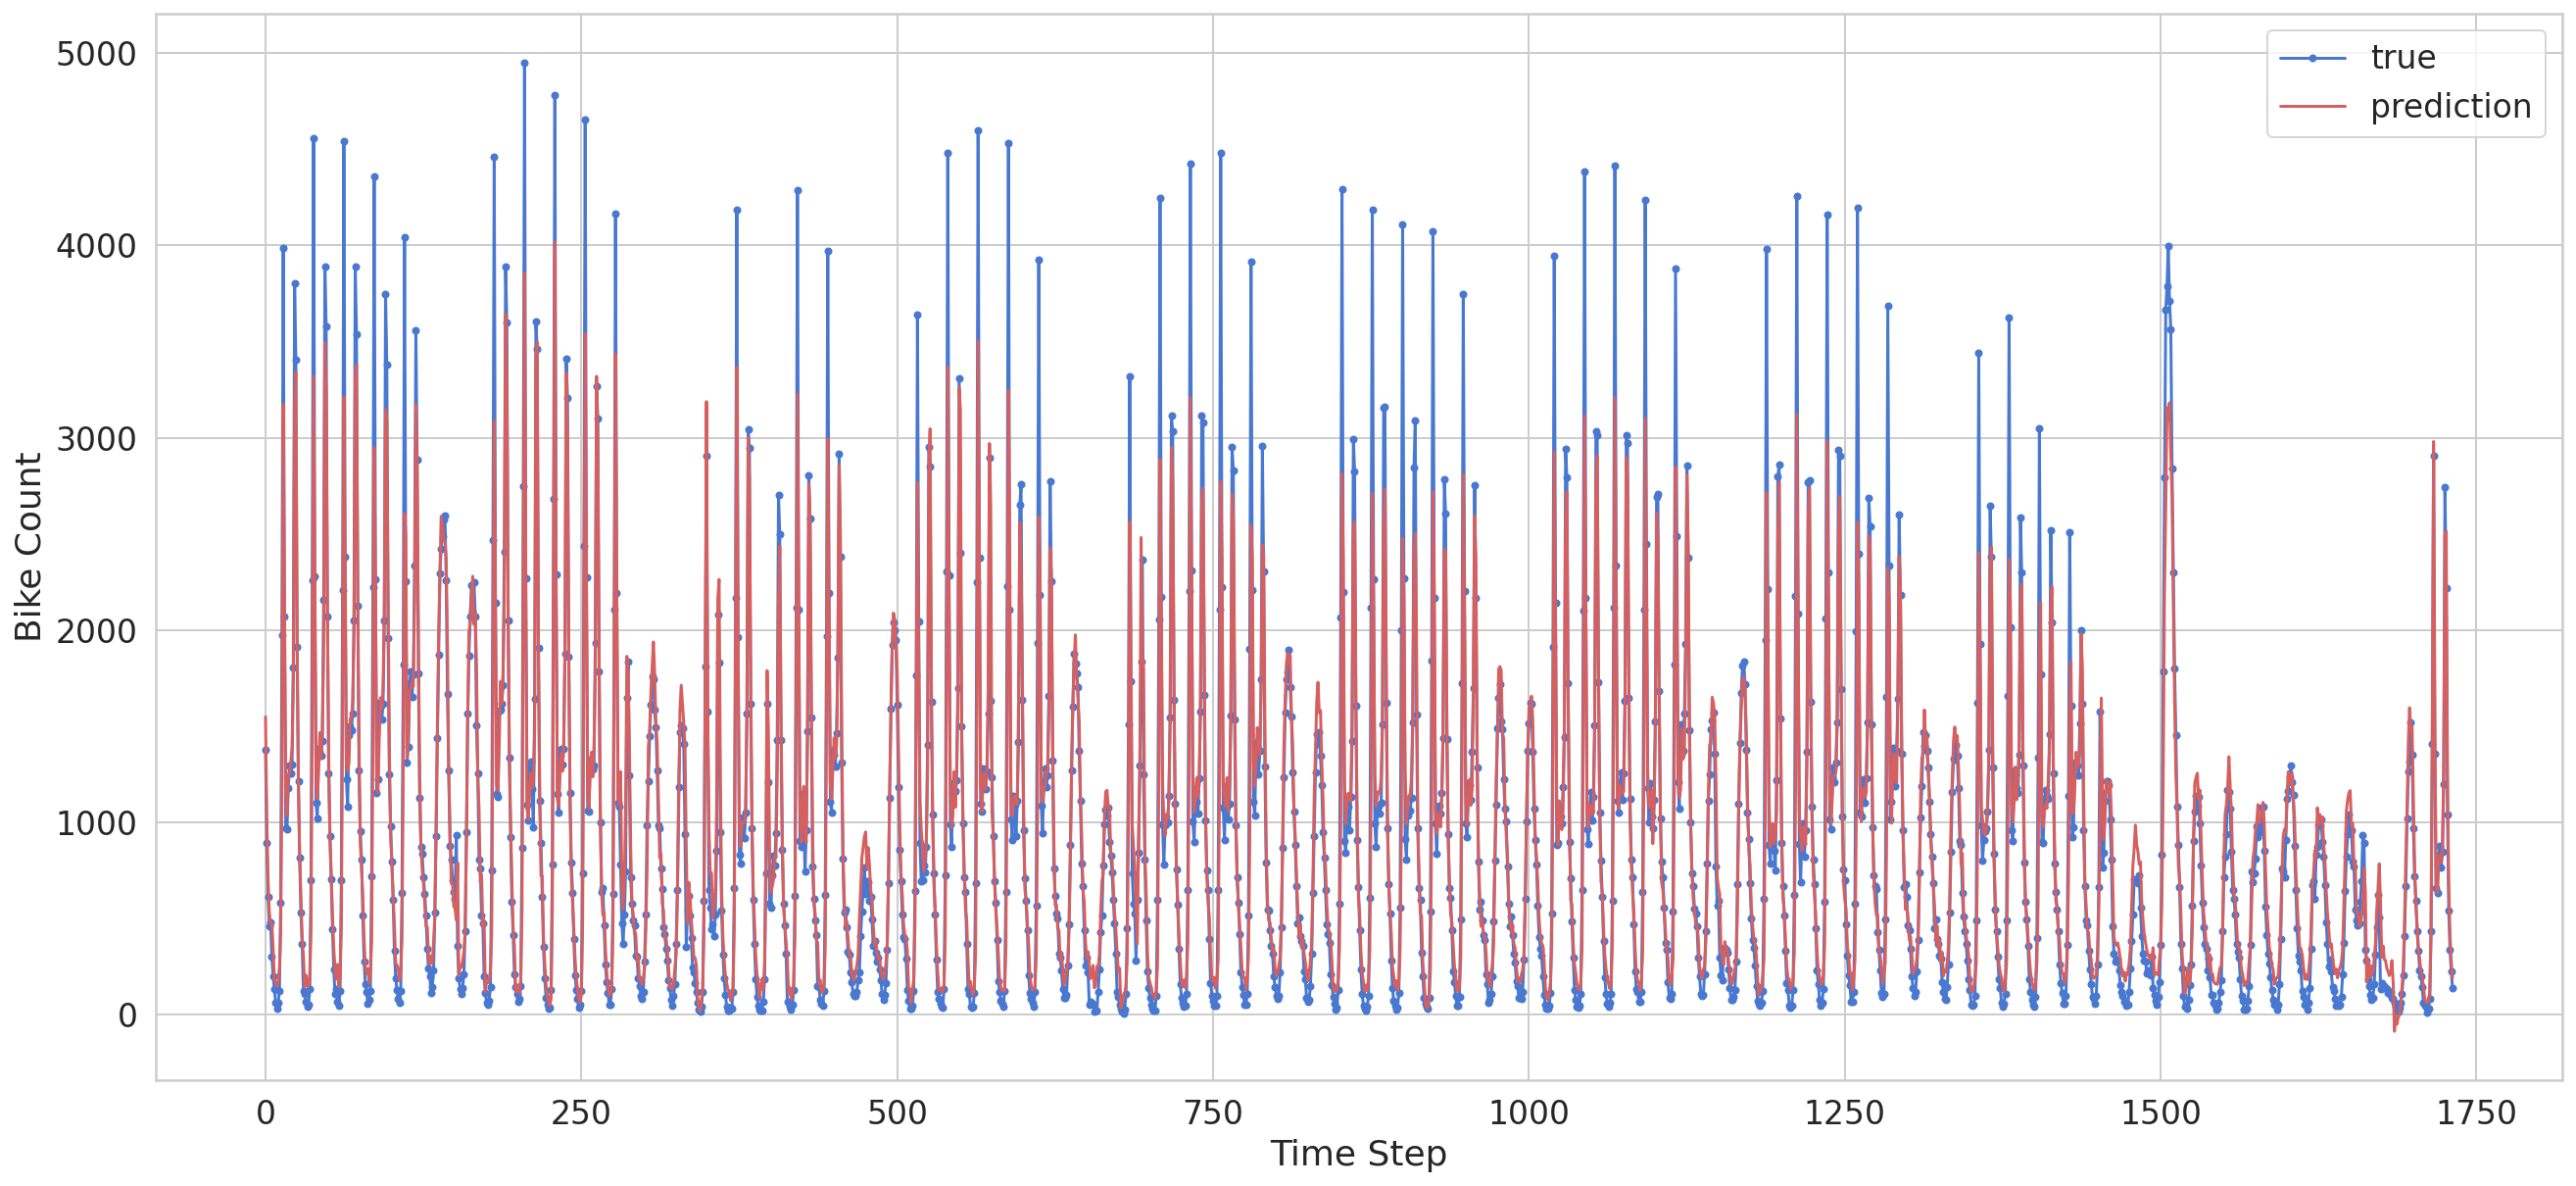

In [20]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();